In [11]:
%pylab notebook
import os, pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Generate Finite Element Modeling inputs

In [ ]:
keep = [
    'tapeid', 
    'anneal', 
    'ibeam', 
    'ibeam_std', 
    'energy', 
    'power', 
    'powerError', 
    'tREBCO', 
    'tHTS_ON', 
    'tHTS_OFF', 
    'tTAR_ON', 
    'tTAR_OFF'
]

newNames = {
    'tapeid': 'tape',
    'anneal': 'anneal',
    'ibeam': 'ibeam',
    'ibeam_std': 'ibeam_std',
    'energy': 'energy',
    'power': 'power',
    'powerError': 'powerError',
    'tREBCO': 'tREBCO',
    'tHTS_ON': 'tTape_ON',
    'tHTS_OFF': 'tTape_OFF',
    'tTAR_ON': 'tTarget_ON',
    'tTAR_OFF': 'tTarget_OFF'
}

tape = 'f19'
dataForNico = data[(data.tapeid == tape) & (data.anneal == 1)][keep].rename(newNames)
dataForNico.to_excel('../data/fem/inputs/modelinput-{}-1.xlsx'.format(tape))

## Check Finite Element Model inputs

<IPython.core.display.Javascript object>


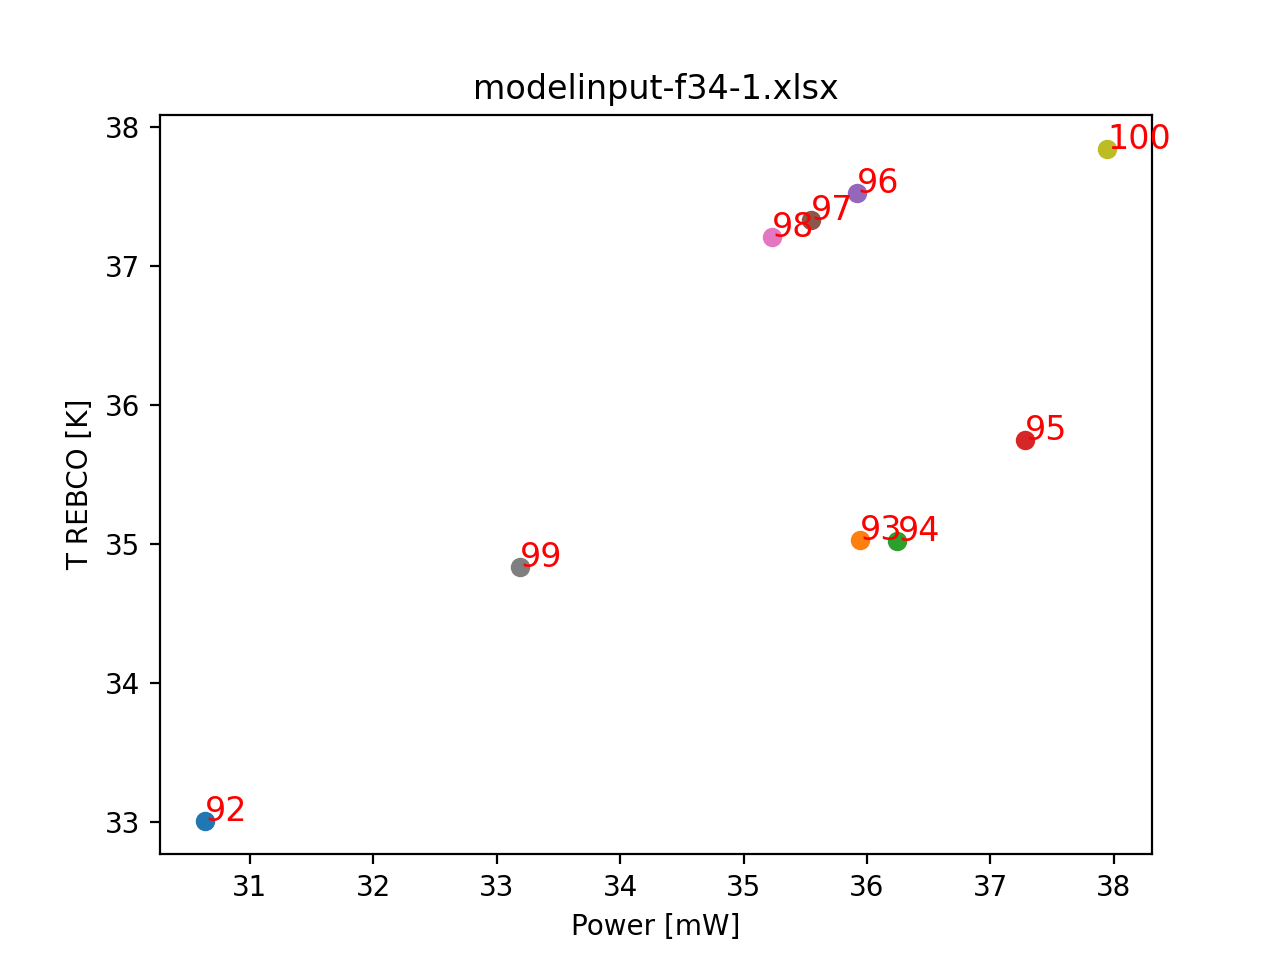

89
90
91
92
93
94
95
96
97


Text(0, 0.5, 'T REBCO [K]')

In [58]:
path = '/Users/alexisdevitre/Documents/GitHub/2024-Beam-On-Not/data/fem/inputs/'

fpaths = [path+f for f in os.listdir(path) if '.DS_Store' not in f]
fpath = fpaths[0]
data = pd.read_excel(fpath, skiprows=0)

fig, ax = plt.subplots()

for i, r in data.iterrows():
    print(r.iloc[0])
    ax.plot(r.power, r.tREBCO, linestyle='None', marker='o')
    ax.text(r.power, r.tREBCO, str(r.iloc[0]+3), color="red", fontsize=12)
    
#x, y = data.power, data.tREBCO
#ax.plot(x, y, marker='o', linestyle='None')
ax.set_title(fpath.split('/')[-1])
ax.set_xlabel('Power [mW]')
ax.set_ylabel('T REBCO [K]')


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fitfunction = ff.affine
xsmooth = np.linspace(0, 200, 1000)

datasets = ['f29-1', 'f29-2', 'f37-1', 'f33-1'] #, 'f37-2'
energies = [150, 1200, 1200, 150]
markers = ['+', 'x', '^', 'v', '.']
colors = sns.color_palette('flare', len(datasets))

for dataset, energy, m, c in zip(datasets, energies, markers, colors):
    tape = dataset.split('-')[0]
    
    cut = (data.tapeid == tape)
    cut &= (data.energy == energy)
    if int(dataset.split('-')[1]) > 1:
        cut &= (data.anneal > 1)
    else:
        cut &= (data.anneal == 1)
    cut &= (data.tREBCO-data.tTAR_ON > 0) # Some corrections fail and produce tREBCO = 0, which leads to a negative dT.
    d = data[cut]
    
    # plot the data and affine fit
    x, ex = d.power, d.powerError
    y, ey = d.tREBCO-d.tTAR_ON, np.zeros_like(d.powerError)
    popt, pcov = curve_fit(ff.affine, x, y)
    ax.plot(xsmooth, ff.affine(xsmooth, *popt), color=c, alpha=1, linewidth=1)
    ax.plot(x, y, linestyle='None', linewidth=.5, marker=m, markersize=6, alpha=.6, color=c)
    
    # plot model fit
    path_to_files = '../data/fem/{}/{}keV/'.format(dataset, energy)
    minThickness, maxThickness = 100, 0 # find the extreme cases of the simulation 
    for fpath in [path_to_files+f for f in os.listdir(path_to_files) if 'DS_Store' not in f]:
        thickness = float(fpath.split('/')[-1].split('=')[1].split('um+')[0])
        if thickness < minThickness: minThickness = thickness
        if thickness > maxThickness: maxThickness = thickness
    
    if float(int(minThickness)) == minThickness: minThickness = int(minThickness)
    if float(int(maxThickness)) == maxThickness: maxThickness = int(maxThickness)
    
    # get lower bound fit
    fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, minThickness)
    d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
    x, y = d.ibeam*energy*1e-3, d.dTREBCO
    popt_lower, _ = curve_fit(ff.affine, x, y)

    fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, maxThickness)
    d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
    x, y = d.ibeam*energy*1e-3, d.dTREBCO
    popt_upper, _ = curve_fit(ff.affine, x, y)

    xsmooth = np.linspace(0, 200, 10000)
    ylower = ff.affine(xsmooth, *popt_lower)
    yupper = ff.affine(xsmooth, *popt_upper)
    ax.fill_between(x=xsmooth, y1=ylower, y2=yupper, color=c, alpha=.3)

ax.set_title('{}, {} keV'.format(dataset, energy))
ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel('$\mathrm{T_{REBCO} - T_{Cold mass}}$ [K]')
ax.set_xlim(0, 150)
ax.set_ylim(0, 40)
#ax.set_yticks([0, 3, 6, 9, 12, 15, 18])
fig.tight_layout()
#ax.legend()
plt.savefig(outputDirectory+'thermal-resistance.svg', format='svg', facecolor='white')